### Урок №4

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: 
    - одна модель с признаком коммуникации (S learner), 
    - модель с трансформацией таргета (трансформация классов п. 2. 1) 
    - вариант с двумя независимыми моделями
    
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 
    - сделать прогноз и получить uplift для тестовой выборки 
    - отсортировать тестовую выборку по uplift по убыванию 
    - разбить на децили (pandas qcut вам в помощь) 
    - для каждого дециля посчитать среднюю conversion
    
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [4]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

In [5]:
df.sample(4)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
32412,5,153.01,1,0,Urban,0,Web,Discount,0
36966,10,29.99,0,1,Urban,0,Phone,Discount,1
11568,8,29.99,0,1,Urban,1,Phone,No Offer,0
7849,11,29.99,1,0,Surburban,1,Phone,Buy One Get One,0


In [6]:
df['treatment'] = df['treatment'].replace({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})

In [7]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [8]:
df.sample(4)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
51832,6,68.17,0,1,Surburban,1,Web,0,0
12881,3,252.14,1,0,Surburban,0,Phone,1,0
51801,10,129.42,0,1,Urban,1,Web,1,0
60114,9,29.99,1,0,Surburban,1,Web,1,0


In [9]:
# Извлечение признаков
df_features = df.copy()
df_target = df.copy()

df_features = df_features.drop('target', axis=1)
df_features = df_features.drop('treatment', axis=1)

In [10]:
indices_learn, indices_valid = train_test_split(df.index, test_size=0.3, random_state=42)

In [11]:
X_train = df_features.loc[indices_learn, :]
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df.loc[indices_valid, 'target']
treat_val = df.loc[indices_valid, 'treatment']

X_train_full = df_features
y_train_full = df.loc[: ,'target']
treat_train_full = df.loc[: ,'treatment']

X_test = df_features

cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@30%':[]
}

### 1. Подходы с одной моделью
#### 1.1 Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

In [12]:
#pip install scikit-uplift

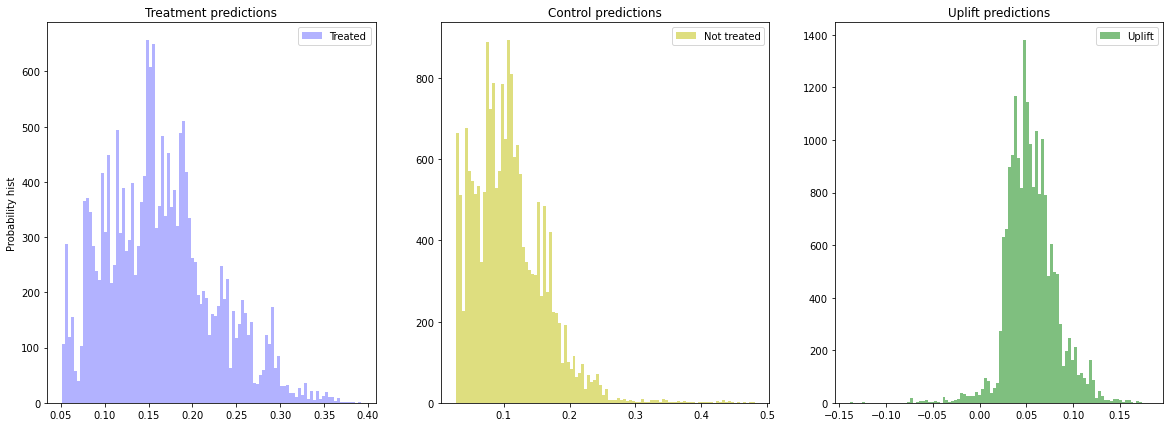

In [13]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [14]:
n = 20
df = pd.DataFrame({
    'true': y_val[:n],
    'uplift': uplift_sm[:n],
    'treat': treat_val[:n]
    })
df

,true,uplift,treat
33042,0,0.032169,1
7209,0,0.084523,1
24367,0,0.066616,1
19599,1,0.058384,1
31465,1,0.169083,1
32504,0,0.070323,0
23080,1,0.075917,1
7168,0,0.026326,0
26195,0,0.033693,0
36096,0,-0.023554,0


### Посмотрим на топ-признаки

In [15]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,21.870359
1,treatment,17.348516
2,used_bogo,14.188694
3,zip_code,11.348090
4,channel,9.318912
5,recency,9.011429
6,history,8.504662
7,used_discount,8.409336


### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

In [16]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

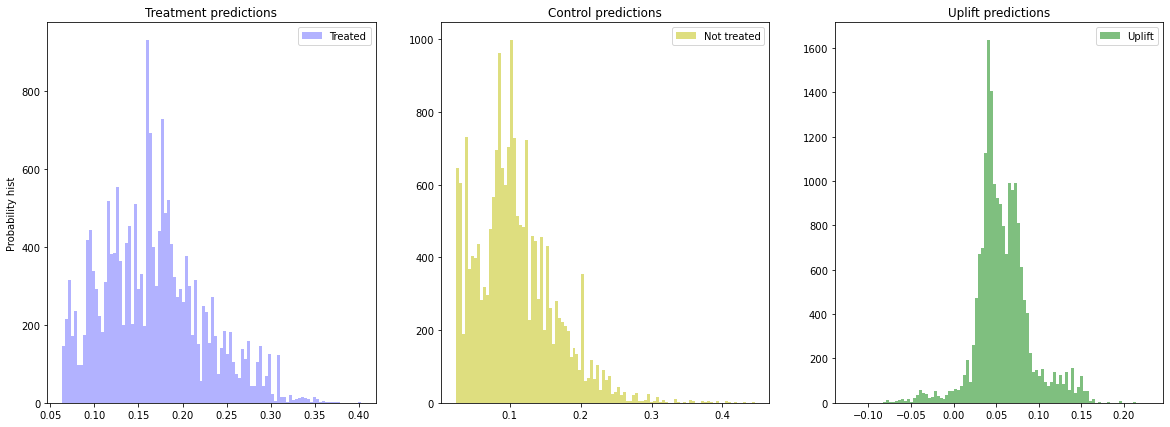

In [17]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### Посмотрим на результаты

In [18]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.092650
1,ClassTransformation,0.087555
2,TwoModels,0.078819


Solo Model


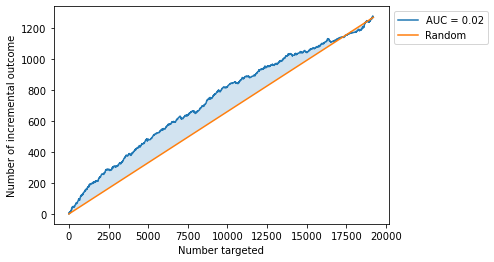

Two Model


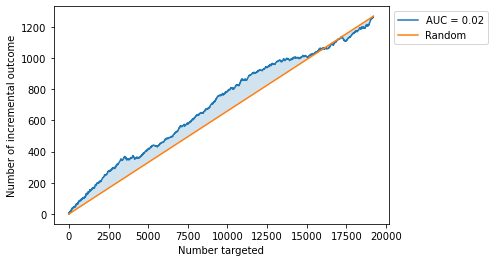

ClassTransform Model


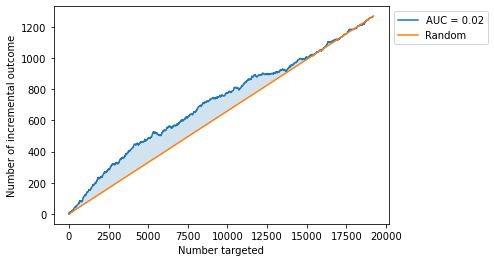

In [19]:
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_uplift_preds

print('Solo Model')
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=False)
plt.show()

print('Two Model')
plot_uplift_curve(y_val, uplift_tm, treat_val, perfect=False)
plt.show()

print('ClassTransform Model')
plot_uplift_curve(y_val, uplift_ct, treat_val, perfect=False)
plt.show()

In [20]:
from sklift.metrics import uplift_by_percentile

uplift_by_percentile(y_val, uplift_sm, treat_val, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

/home/artcom5/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1298,622,0.258089,0.136656,0.121433,0.012146,0.013772,0.018363
10-20,1276,644,0.192006,0.114907,0.077099,0.011026,0.012567,0.016718
20-30,1260,660,0.180159,0.101515,0.078644,0.010827,0.011756,0.015982
30-40,1285,635,0.174319,0.111811,0.062508,0.010583,0.012506,0.016383
40-50,1274,646,0.169545,0.095975,0.073570,0.010513,0.011589,0.015647
50-60,1273,647,0.142184,0.095827,0.046357,0.009788,0.011572,0.015157
60-70,1274,646,0.153061,0.102167,0.050894,0.010087,0.011916,0.015612
70-80,1254,666,0.141148,0.099099,0.042049,0.009832,0.011578,0.015190
80-90,1291,629,0.119287,0.077901,0.041386,0.009021,0.010687,0.013985


/home/artcom5/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


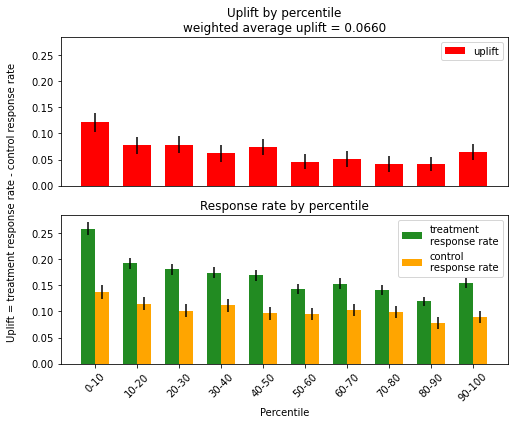

In [21]:
from sklift.viz import plot_uplift_by_percentile

plot_uplift_by_percentile(y_val, uplift_sm, treat_val,
                         strategy='overall',
                         kind='bar');

### Вариант с деревом решений

In [22]:
X_train

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
9656,7,434.35,1,0,Urban,1,Web
63037,1,376.59,1,0,Surburban,0,Multichannel
31405,3,140.34,0,1,Urban,1,Phone
58088,3,150.76,0,1,Surburban,0,Web
44344,2,67.97,1,0,Surburban,1,Phone
...,...,...,...,...,...,...,...
62570,3,276.21,0,1,Urban,0,Phone
38158,4,43.49,0,1,Urban,0,Phone
860,8,492.53,1,1,Rural,1,Phone
15795,5,72.28,1,0,Urban,1,Web


In [23]:
X_train_tree = pd.concat([X_train.drop(['zip_code', 'channel'], axis=1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code'), 
                          pd.get_dummies(X_train['channel'], prefix='channel')
                         ], axis=1)

features = [col for col in X_train_tree]
features

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'is_referral',
 'zip_code_Rural',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Multichannel',
 'channel_Phone',
 'channel_Web']

In [24]:
#!pip3 install causalml

In [25]:
#!pip3 install -U scikit-learn

In [26]:
%%time

from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot


uplift_model = UpliftTreeClassifier(max_depth=4, 
                                    min_samples_leaf=200, 
                                    min_samples_treatment=50,
                                    n_reg=100,
                                    evaluationFunction='KL',
                                    control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

CPU times: user 2.8 s, sys: 140 ms, total: 2.94 s
Wall time: 2.97 s


In [27]:
display(Image(graph.create_png()))

InvocationException: GraphViz's executables not found